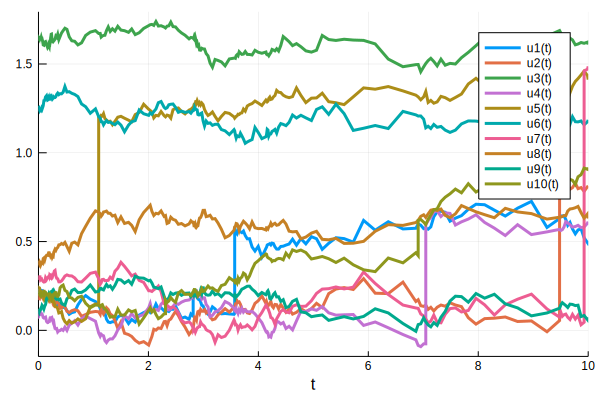

In [10]:
using DifferentialEquations ,BenchmarkTools,  StochasticDiffEq, DiffEqJump, Plots, Parameters
using Distributions
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end

function affect!(integrator)
    #draw
    sort_u = sort(integrator.u)
    F = range(0.0, 1, length = integrator.p.N)
    draw_quantile = rand()  # draw quantile on (0,1)
    u_n_2 = sort_u[findlast(q -> q <= draw_quantile, F.^integrator.p.κ)]
    #firm facing a jump
    n = rand(1:integrator.p.N)
    integrator.u[n] =max(integrator.u[n], u_n_2)
end

params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 10, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:10., # time steps to save
    κ = 0.5, #changing distribution
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 2, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    volatility = volatility, 
    affect! = affect!, # jump process 
    rate = rate)



function generate_jump_prob(p)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jump = ConstantRateJump(rate, p.affect!)
    jump_prob = JumpProblem(sde_prob, Direct(), jump)
    return jump_prob
end
rate(u,p,t) = 0.2*p.N
p = params()
sol = solve(generate_jump_prob(p), SRIW1())
plot(sol)